In this project, we will study the various properties of Internet Movie
Database (IMDb). In the first part of the project, we will explore the
properties of a directed actor/actress network. In the second part of the
project, we will explore the properties of an undirected movie network.

In [1]:
library(doParallel)
library(igraph)
library(tictoc)
library(MASS)


Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [87]:
cast_movieFD <- file("cast_movie.rds", "rb")
cast_movie <-readRDS(file = cast_movieFD)
close(cast_movieFD)

edgeListFD <- file("edgeList.rds", "rb")
edgeList <-readRDS(edgeListFD)
close(edgeListFD)

cast_movie_modFD <- file("cast_movie_mod.rds", "rb")
cast_movie_mod <-readRDS(cast_movie_modFD)
close(cast_movie_modFD)

castGFD <- file("castG.rds", "rb")
cast_g <-readRDS(castGFD)
close(castGFD)

PageRankFD <- file("PageRank.rds", "rb")
cast_PR <- readRDS(PageRankFD)
close(PageRankFD)

### 1 Actor/Actress network
In this part of the project, we will create the network using the data from the following text files:

 - actor_movies.txt

 - actress_movies.txt

The text files can be downloaded from the following link:

https://ucla.box.com/s/z45q3g5zrpay8b8gtbql6ojaecb7kj2u

In order to create the network in a consistent manner, you will need to do some data preprocessing. The preprocessing consists of 2 parts:

1. Merging the two text files into one and then removing the actor/actress who has acted in less than 10 movies

2. Cleaning the merged text file

The cleaning part is necessary to avoid inconsistency in the network
creation. If you analyze the merged text file, then you will observe
that same movie might be counted multiple times due to the role of the
actor/actress in that movie. For example, we might have

 - Movie X (voice)

 - Movie X (as uncredited)

If you don’t clean the merged text file, then Movie X (voice) and Movie X (as uncredited) will be considered as different movies. Therefore, you will need to perform some cleaning operations to remove inconsistencies of various types.

#### Question 1: Perform the preprocessing on the two text files and report the total number of actors and actresses and total number of unique movies that these actors and actresses have acted in.

In [2]:
## read actor- & actress-movie list from the files
filmNumBar = 10


actorDir = "./project4_data-selected/actor_movies.txt"
actressDir = "./project4_data-selected/actress_movies.txt"

cast_movie = list()
actorFD = file(actorDir, "r")
while (length(oneLine <- readLines(actorFD, n = 1, warn = FALSE, encoding = "latin1")) > 0) {
    fileVector <- strsplit(oneLine, "\t\t")
    numFilms <- length(fileVector[[1]])

    if(numFilms > filmNumBar){
        cast_movie[[fileVector[[1]][1]]] <- tail(fileVector[[1]], numFilms - 1)
    }
} 
close(actorFD)

actressFD = file(actressDir, "r")
while (length(oneLine <- readLines(actressFD, n = 1, warn = FALSE,  encoding = "latin1")) > 0) {
    fileVector <- strsplit(oneLine, "\t\t")
    numFilms <- length(fileVector[[1]])

    if(numFilms > filmNumBar){
        cast_movie[[fileVector[[1]][1]]] <- tail(fileVector[[1]], numFilms - 1)
    }
} 
close(actressFD)

cast_movieFD <- file("cast_movie.rds", "wb")
saveRDS(cast_movie , file = cast_movieFD)
close(cast_movieFD)


In [3]:
cl <- makeCluster(7)
registerDoParallel(cl)

In [4]:
##parallel version of process the cast_movie
tic()
cast = names(cast_movie)
numCast = length(cast)

##remove all the content that surrounded by pairs of parentheses and the white space before/after the parentheses 
cast_movie_mod <- foreach(i = 1:numCast, .inorder = TRUE) %dopar%{
    gsub("\\s*\\([^\\(\\)]*\\)\\s*", "",  cast_movie[[i]])
}
toc()

##save the modified data 
cast_movie_modFD <- file("cast_movie_mod.rds", "wb")
saveRDS(cast_movie_mod , file = cast_movie_modFD)
close(cast_movie_modFD)

92.28 sec elapsed


In [5]:
## Finding out how many movies and unique cast are found in the data
uniqueMovie = unique(unlist(cast_movie_mod))
numMovie <- length(uniqueMovie)
numCast <-length(cast_movie_mod)
print(numMovie)
print(numCast)

1.1 Directed actor/actress network creation
We will use the processed text file to create the directed actor/actress network. The nodes of the network are the actor/actress and there are weighted edges between the nodes in the network. The weights of the edges are given by equation 1:

$\omega_{i\rightarrow j}= \frac{|S_i \cap U_j|}{|S_i|}$

where Si is the set of movies in which actor/actress vi has acted in and Sj is the set of movies in which actor/actress vj has acted in.

#### Question 2: Create a weighted directed actor/actress network using the processed text file and equation 1. Plot the in-degree distribution of the actor/actress network. Briefly comment on the in-degree distribution.

In [6]:
tic()
cast_movie_mod <- foreach(i = 1:numCast, .inorder = TRUE) %dopar%{
     match(cast_movie_mod[[i]], uniqueMovie)
}
toc()

7333.04 sec elapsed


In [7]:
##generate the edgelist  

tic()
edgeList <- foreach(i=1:numCast, .combine='rbind') %dopar%{
    weight <- numeric(numCast)
    tempCastFilm <- cast_movie_mod[[i]]
    numOfCastFile <- length(tempCastFilm)
    for(j in 1:numCast){
        weight[j] <- length(intersect(tempCastFilm, cast_movie_mod[[j]]))
    }
    to = which(weight != 0)
    to <- to[to != i]
    weight = weight[to]/numOfCastFile
    
    currentNodeDegree <- length(to)
    from = rep(i, currentNodeDegree)
    cbind(from, to, weight)
}
toc()

##save the data frame in case of lost power and data
edgeListFD <- file("edgeList.rds", "wb")
saveRDS(edgeList , file = edgeListFD)
close(edgeListFD)

22773.56 sec elapsed


In [8]:
stopCluster(cl)

In [3]:
tic()
cast_g <- graph_from_data_frame(edgeList, directed = TRUE)
toc()
castGFD <- file("castG.rds", "wb")
saveRDS(cast_g , file = castGFD)
close(castGFD)

233.14 sec elapsed


[1] 425.6703
[1] 11271


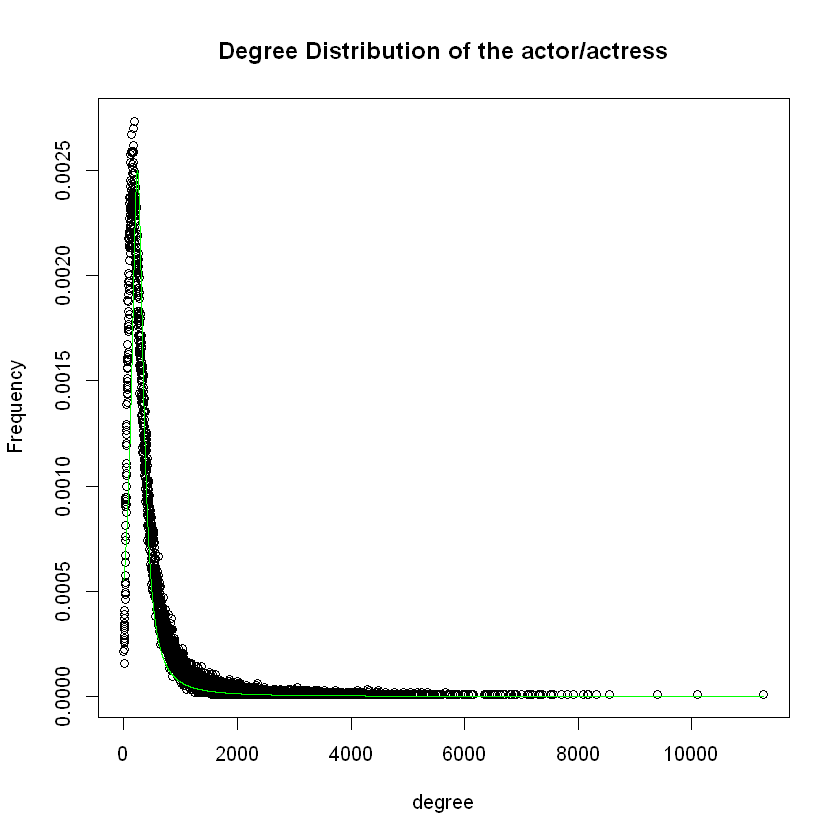

In [235]:
cast_degree_distribution <- degree_distribution(cast_g, mode = "in")
cast_degree_distribution1 <- cast_degree_distribution[which(cast_degree_distribution != 0)]
print(mean(degree(cast_g, mode = "in")))
print(max(degree(cast_g, mode = "in")))

x1 <- which(cast_degree_distribution != 0)
plot(x1, cast_degree_distribution1, main = "Degree Distribution of the actor/actress", xlab = "degree", ylab = "Frequency")
x = 1:max(degree(cast_g, mode = "in"))
para = fitdistr(degree(cast_g, mode = "in"), "cauchy", lower=c(0,0))
y = dcauchy(x, location = 240.0719118, scale = 127.4253074)
lines(x, y, col="green")

In [241]:
print(which(degree(cast_g, mode = "in") == max(degree(cast_g, mode = "in"))))
print(V(cast_g)[which(degree(cast_g, mode = "in") == max(degree(cast_g, mode = "in")))])
print(names(cast_movie)[85724])
print(length(cast_movie[[names(cast_movie)[85724]]]))
print(names(cast_movie)[85688])
print(length(cast_movie[[names(cast_movie)[85688]]]))

85724 
85688 
+ 1/113084 vertex, named, from 5307a16:
[1] 85724
[1] "Flowers, Bess"
[1] 828
[1] "Flockhart, Calista"
[1] 16


1.2 Actor pairings
In this section, we will try to find the pairings between actors. We will
consider the following 10 actors:
 - Tom Cruise
 - Emma Watson (II)
 - George Clooney
 - Tom Hanks
 - Dwayne Johnson (I)
 - Johnny Depp
 - Will Smith (I)
 - Meryl Streep
 - Leonardo DiCaprio
 - Brad Pitt

#### Question 3: Design a simple algorithm to find the actor pairings. To be specific, your algorithm should take as input one of the actors listed above and should return the name of the actor with whom the input actor prefers to work the most. Run your algorithm for the actors listed above and report the actor names returned by your algorithm. Also for each pair, report the (input actor, output actor) edge weight. Does all the actor pairing make sense?

In [3]:
## get the ID of the cast
target_cast = c('Cruise, Tom', "Watson, Emma (II)", "Clooney, George", "Hanks, Tom", "Johnson, Dwayne (I)", "Depp, Johnny", "Smith, Will (I)", "Streep, Meryl", "DiCaprio, Leonardo", "Pitt, Brad")


In [163]:
##get the id of the cast and this is also the symbolic ID in cast_g
cast_IDs = list()
for (cast in target_cast){
    cast_IDs[[cast]] <- which(names(cast_movie) == cast)
}
##find the vertex of the cast also the numerate ID in cast_g
vIDs = list()
for (cast in target_cast){
    vIDs[[cast]] <- which(V(cast_g)$name == cast_IDs[[cast]])
}

In [144]:
cast_edgeList = list()
for(cast in target_cast){
    cast_edgeList[[cast]] = E(cast_g)[from(vIDs[[cast]])]
}
cast_edgeListFD <- file("cast_edgeList.rds", "wb")
saveRDS(cast_edgeList , file = cast_edgeListFD)
close(cast_movie_modFD)

In [147]:
heaviest_cast_edge = list()
for(cast in target_cast){
    heaviest_cast_edge[[cast]] = cast_edgeList[[cast]][match(max(cast_edgeList[[cast]]$weight), cast_edgeList[[cast]]$weight)]
}

##find the endpoints of heaviest edge
heaviest_edge_EP = list()
for(cast in target_cast){
    heaviest_edge_EP[[cast]] = ends(cast_g, heaviest_cast_edge[[cast]])
}

In [162]:
for(cast in target_cast){
    mostLovedID = as.numeric(heaviest_edge_EP[[cast]][2])
    print(sprintf("The actor %s loves to play with %s movies, and they play %d movie together. They two are connected by an edge of weight %6.2f",
                  cast, names(cast_movie)[mostLovedID], round(heaviest_cast_edge[[cast]]$weight * length(cast_movie_mod[[cast_IDs[[cast]]]])), heaviest_cast_edge[[cast]]$weight))

}


[1] "The actor Cruise, Tom loves to play with Kidman, Nicole movies, and they play 11 movie together. They two are connected by an edge of weight   0.17"
[1] "The actor Watson, Emma (II) loves to play with Radcliffe, Daniel movies, and they play 13 movie together. They two are connected by an edge of weight   0.52"
[1] "The actor Clooney, George loves to play with Damon, Matt movies, and they play 8 movie together. They two are connected by an edge of weight   0.12"
[1] "The actor Hanks, Tom loves to play with Allen, Tim (I) movies, and they play 8 movie together. They two are connected by an edge of weight   0.10"
[1] "The actor Johnson, Dwayne (I) loves to play with Austin, Steve (IV) movies, and they play 16 movie together. They two are connected by an edge of weight   0.21"
[1] "The actor Depp, Johnny loves to play with Bonham Carter, Helena movies, and they play 8 movie together. They two are connected by an edge of weight   0.08"
[1] "The actor Smith, Will (I) loves to play with 

1.3 Actor rankings

In this section, we will extract the top 10 actor/actress from the network.

#### Question 4: Use the google’s pagerank algorithm to find the top 10 actor/actress in the network. Report the top 10 actor/actress and also the number of movies and the in-degree of each of the actor/actress in the top 10 list. Does the top 10 list have any actor/actress listed in the previous section? If it does not have any of the actor/actress listed in the previous section, please provide an explanation for this phenomenon.



In [32]:
cast_PR <- page_rank(cast_g, algo = "prpack",  directed = TRUE, damping = 0.85)
PageRankFD <- file("PageRank.rds", "wb")
saveRDS(cast_PR, file = PageRankFD)
close(PageRankFD)

In [71]:
## find the numerate ID of top ten pageRank
topTenPR = order(cast_PR$vector, decreasing=TRUE)[1:10]

## find the symbolic ID of top ten page Rank
for (vID in vIDs){
    if (vID %in% topTenPR){
        sprintf("found \\s in top ten", vID )
    }
}

In [145]:
topTenCastID = V(cast_g)$name[topTenPR]
topTenCastID = as.numeric(topTenCastID)
print("Top Ten PR cast and the number of fils they have participated")

for (i in 1:10){
    castName <- names(cast_movie)[topTenCastID[i]]
    filmsNum <- length(cast_movie_mod[[topTenCastID[i]]])
    inDegree <- degree(cast_g,mode = "in")[topTenPR[i]]
    print(sprintf("The actor %s has participated in %d movies, and his/her in-degree is %6.2e", castName, filmsNum, inDegree))
}


[1] "Top Ten PR cast and the number of fils they have participated"
[1] "The actor Flowers, Bess has participated in 828 movies, and his/her in-degree is 1.13e+04"
[1] "The actor Harris, Sam (II) has participated in 600 movies, and his/her in-degree is 1.01e+04"
[1] "The actor Miller, Harold (I) has participated in 561 movies, and his/her in-degree is 9.39e+03"
[1] "The actor Phelps, Lee (I) has participated in 647 movies, and his/her in-degree is 8.16e+03"
[1] "The actor Farnum, Franklyn has participated in 565 movies, and his/her in-degree is 8.32e+03"
[1] "The actor O'Connor, Frank (I) has participated in 623 movies, and his/her in-degree is 7.32e+03"
[1] "The actor Steers, Larry has participated in 546 movies, and his/her in-degree is 7.81e+03"
[1] "The actor Sullivan, Charles (I) has participated in 512 movies, and his/her in-degree is 7.52e+03"
[1] "The actor Sayre, Jeffrey has participated in 430 movies, and his/her in-degree is 8.09e+03"
[1] "The actor Holmes, Stuart (I) has pa

#### Question 5: Report the pagerank scores of the actor/actress listed in the previous section. Also, report the number of movies each of these actor/actress have acted in and also their in-degree.

In [146]:
for (cast in target_cast){
     castPR <-cast_PR$vector[vIDs[[cast]]]
     filmsNum <- length(cast_movie_mod[[cast_IDs[[cast]]]])
     inDegree <- degree(cast_g, mode = "in")[vIDs[[cast]]]
     print(sprintf("The actor %s has participated in %d movies, his/her PageRank is %8.2e, his/her in-degree is %8.2e",cast, filmsNum, castPR, inDegree))
}

[1] "The actor Cruise, Tom has participated in 63 movies, his/her PageRank is 3.27e-05, his/her in-degree is 2.05e+03"
[1] "The actor Watson, Emma (II) has participated in 25 movies, his/her PageRank is 1.36e-05, his/her in-degree is 5.88e+02"
[1] "The actor Clooney, George has participated in 67 movies, his/her PageRank is 3.03e-05, his/her in-degree is 1.89e+03"
[1] "The actor Hanks, Tom has participated in 80 movies, his/her PageRank is 3.96e-05, his/her in-degree is 2.39e+03"
[1] "The actor Johnson, Dwayne (I) has participated in 78 movies, his/her PageRank is 3.22e-05, his/her in-degree is 1.62e+03"
[1] "The actor Depp, Johnny has participated in 98 movies, his/her PageRank is 4.19e-05, his/her in-degree is 2.61e+03"
[1] "The actor Smith, Will (I) has participated in 49 movies, his/her PageRank is 2.45e-05, his/her in-degree is 1.52e+03"
[1] "The actor Streep, Meryl has participated in 97 movies, his/her PageRank is 3.03e-05, his/her in-degree is 1.83e+03"
[1] "The actor DiCaprio,